In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_parquet('data/balanced_train.parquet')
df = df[['id', 'protein_name', 'binds']]
df

,id,protein_name,binds
0,45074911,HSA,0
1,21655935,BRD4,1
2,82557269,sEH,1
3,195673909,HSA,1
4,228828477,BRD4,1
...,...,...,...
3179807,246081175,HSA,1
3179808,204050511,BRD4,0
3179809,17310517,HSA,1
3179810,83607662,sEH,1


In [3]:
df = pd.concat([df, pd.get_dummies(df['protein_name'], dtype=int)], axis=1)
df = df.drop(columns=['protein_name'])
df = df[['id',  'BRD4', 'HSA', 'sEH', 'binds']]
df

,id,BRD4,HSA,sEH,binds
0,45074911,0,1,0,0
1,21655935,1,0,0,1
2,82557269,0,0,1,1
3,195673909,0,1,0,1
4,228828477,1,0,0,1
...,...,...,...,...,...
3179807,246081175,0,1,0,1
3179808,204050511,1,0,0,0
3179809,17310517,0,1,0,1
3179810,83607662,0,0,1,1


In [4]:
maccs = pd.read_parquet('data/maccs_embeddings.parquet')
maccs.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166
0,0,0,0,0,0,0,0,0,0,0,...,1,3,1,2,3,3,2,2,3,0
1,0,0,0,0,0,0,0,0,0,0,...,1,3,1,1,3,3,2,2,3,1
2,0,0,0,0,0,0,0,0,0,0,...,1,3,1,1,3,2,2,1,2,1
3,0,0,0,0,0,0,0,0,0,0,...,3,3,1,0,3,3,3,3,3,1
4,0,0,0,0,0,0,0,0,0,0,...,1,3,2,2,3,2,1,3,3,0


In [5]:
minmax = MinMaxScaler()
maccs = minmax.fit_transform(maccs)
maccs[:5]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.33333333, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.66666667, 0.33333333, 0.        , 0.        , 0.        ,
        0.        , 0.33333333, 0.        , 0.  

In [6]:
df = pd.concat([df, pd.DataFrame(maccs)], axis=1)
df.head()

,id,BRD4,HSA,sEH,binds,0,1,2,3,4,...,157,158,159,160,161,162,163,164,165,166
0,45074911,0,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.666667,0.0,1.0,0.5,0.5,1.0,0.0
1,21655935,1,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.0,1.0,0.5,0.5,1.0,0.5
2,82557269,0,0,1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.0,0.5,0.5,0.0,0.5,0.5
3,195673909,0,1,0,1,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.5
4,228828477,1,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.666667,0.0,0.5,0.0,1.0,1.0,0.0


In [7]:
df.shape

(3179812, 172)

In [8]:
y = df['binds']
y[:5]

0    0
1    1
2    1
3    1
4    1
Name: binds, dtype: int64

In [9]:
X = df.drop(columns=['id', 'binds']).values
X[0][-5:]

array([1. , 0.5, 0.5, 1. , 0. ])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
# 72% train, 20% train, 8% val

In [11]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

X_train: (2289464, 170), y_train: (2289464,)
X_test: (635963, 170), y_test: (635963,)
X_val: (254385, 170), y_val: (254385,)


In [12]:
def generate_auc_roc(clf, X_train, y_train):

    y_scores = clf.predict_proba(X_train)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Logistic Regression
classifier = LogisticRegression(penalty='l2',
                                solver='lbfgs',
                                max_iter=1000)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

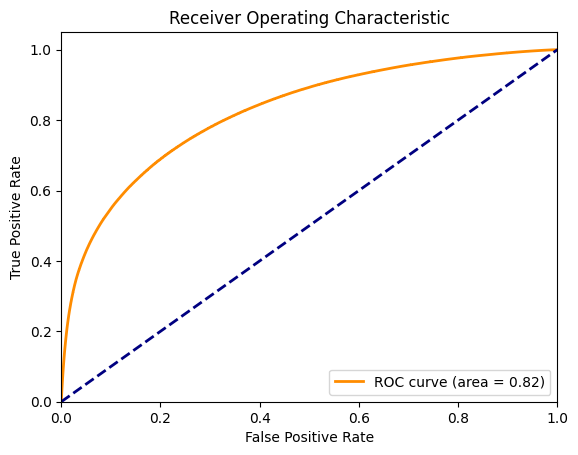

In [14]:
y_scores = classifier.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
y_val_pred = classifier.predict(X_val)
print("val accuracy:", accuracy_score(y_val, y_val_pred))
print("classification report (val set):\n", classification_report(y_val, y_val_pred))

val accuracy: 0.7439510977455431
classification report (val set):
               precision    recall  f1-score   support

           0       0.73      0.76      0.75    127257
           1       0.75      0.72      0.74    127128

    accuracy                           0.74    254385
   macro avg       0.74      0.74      0.74    254385
weighted avg       0.74      0.74      0.74    254385



In [16]:
y_test_pred = classifier.predict(X_test)
print("test accuracy:", accuracy_score(y_test, y_test_pred))
print("classification report (test set):\n", classification_report(y_test, y_test_pred))

test accuracy: 0.745051205809143
classification report (test set):
               precision    recall  f1-score   support

           0       0.74      0.77      0.75    318169
           1       0.76      0.72      0.74    317794

    accuracy                           0.75    635963
   macro avg       0.75      0.75      0.74    635963
weighted avg       0.75      0.75      0.74    635963



In [17]:
# Decision Tree
classifier = DecisionTreeClassifier(criterion='gini',
                                    splitter='best',
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=None,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    class_weight=None,
                                    ccp_alpha=0.0,
                                    monotonic_cst=None)
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

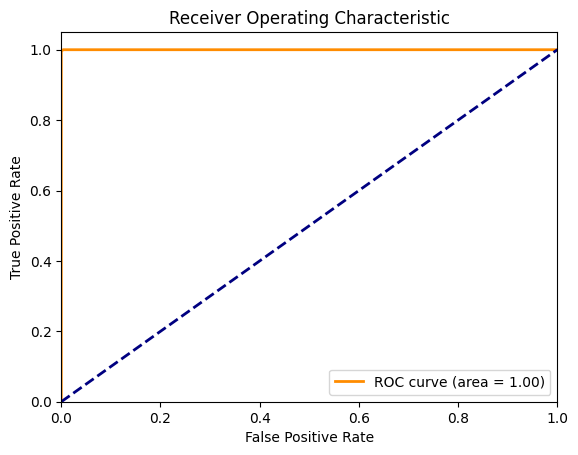

In [18]:
generate_auc_roc(classifier, X_train, y_train)

In [19]:
y_val_pred = classifier.predict(X_val)
print("val accuracy:", accuracy_score(y_val, y_val_pred))
print("classification report (val set):\n", classification_report(y_val, y_val_pred))

val accuracy: 0.865605283330385
classification report (val set):
               precision    recall  f1-score   support

           0       0.87      0.85      0.86    127257
           1       0.86      0.88      0.87    127128

    accuracy                           0.87    254385
   macro avg       0.87      0.87      0.87    254385
weighted avg       0.87      0.87      0.87    254385



In [20]:
y_test_pred = classifier.predict(X_test)
print("test accuracy:", accuracy_score(y_test, y_test_pred))
print("classification report (test set):\n", classification_report(y_test, y_test_pred))

test accuracy: 0.8651022150659708
classification report (test set):
               precision    recall  f1-score   support

           0       0.87      0.85      0.86    318169
           1       0.86      0.88      0.87    317794

    accuracy                           0.87    635963
   macro avg       0.87      0.87      0.87    635963
weighted avg       0.87      0.87      0.87    635963



In [21]:
# Random Forest
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

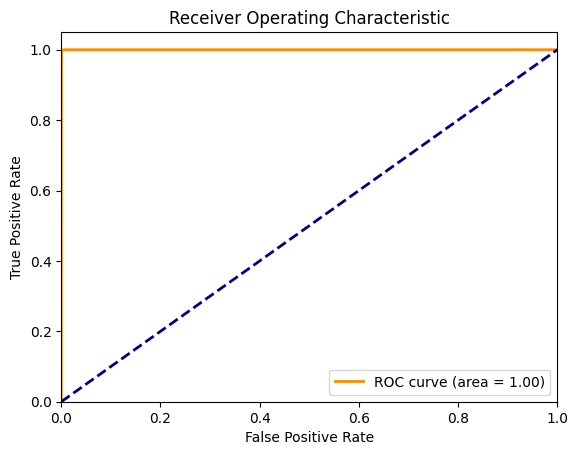

In [22]:
generate_auc_roc(classifier, X_train, y_train)

In [23]:
y_val_pred = classifier.predict(X_val)
print("val accuracy:", accuracy_score(y_val, y_val_pred))
print("classification report (val set):\n", classification_report(y_val, y_val_pred))

val accuracy: 0.9127975313009808
classification report (val set):
               precision    recall  f1-score   support

           0       0.89      0.94      0.91    127257
           1       0.93      0.89      0.91    127128

    accuracy                           0.91    254385
   macro avg       0.91      0.91      0.91    254385
weighted avg       0.91      0.91      0.91    254385



In [24]:
y_test_pred = classifier.predict(X_test)
print("test accuracy:", accuracy_score(y_test, y_test_pred))
print("classification report (test set):\n", classification_report(y_test, y_test_pred))

test accuracy: 0.9120326182498039
classification report (test set):
               precision    recall  f1-score   support

           0       0.89      0.94      0.91    318169
           1       0.93      0.89      0.91    317794

    accuracy                           0.91    635963
   macro avg       0.91      0.91      0.91    635963
weighted avg       0.91      0.91      0.91    635963



In [25]:
# Naive Bayes
classifier = GaussianNB(priors=None,
                        var_smoothing=1e-09)
classifier.fit(X_train, y_train)

GaussianNB()

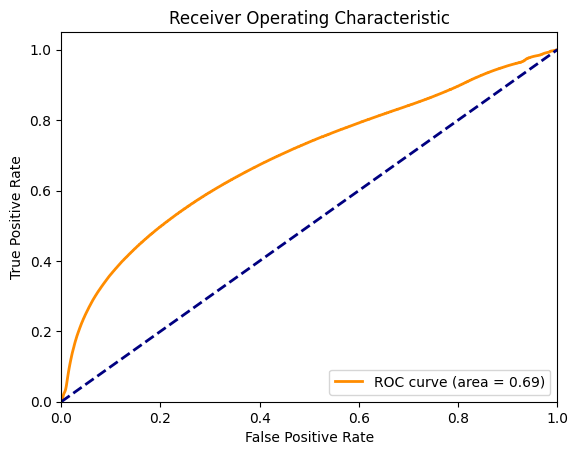

In [26]:
generate_auc_roc(classifier, X_train, y_train)

In [27]:
y_val_pred = classifier.predict(X_val)
print("val accuracy:", accuracy_score(y_val, y_val_pred))
print("classification report (val set):\n", classification_report(y_val, y_val_pred))

val accuracy: 0.5952394991843073
classification report (val set):
               precision    recall  f1-score   support

           0       0.66      0.40      0.49    127257
           1       0.57      0.80      0.66    127128

    accuracy                           0.60    254385
   macro avg       0.61      0.60      0.58    254385
weighted avg       0.61      0.60      0.58    254385



In [28]:
y_test_pred = classifier.predict(X_test)
print("test accuracy:", accuracy_score(y_test, y_test_pred))
print("classification report (test set):\n", classification_report(y_test, y_test_pred))

test accuracy: 0.5942106694886338
classification report (test set):
               precision    recall  f1-score   support

           0       0.66      0.39      0.49    318169
           1       0.57      0.80      0.66    317794

    accuracy                           0.59    635963
   macro avg       0.61      0.59      0.58    635963
weighted avg       0.61      0.59      0.58    635963



In [29]:
# Neural Network
Xt_train = torch.tensor(X, dtype=torch.float)
yt_train = torch.tensor(y.to_numpy(), dtype=torch.long)
Xt_val = torch.tensor(X_val, dtype=torch.float)
yt_val = torch.tensor(y_val.to_numpy(), dtype=torch.long)

In [30]:
print(Xt_train.shape, yt_train.shape, Xt_val.shape, yt_val.shape)

torch.Size([3179812, 170]) torch.Size([3179812]) torch.Size([254385, 170]) torch.Size([254385])


In [31]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(170,32)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(32, 16)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(16, 16)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act_output(self.output(x))
        return x

In [32]:
model = NeuralNetwork()
loss_fn = nn.BCELoss()  # binary cross-entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
def train_model(model, train_data, val_data, loss_fn, optimizer, epochs=10, patience=5):

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(epochs):

        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs.squeeze(), y_batch.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs.squeeze() >= 0.5).long()
            train_correct += (predicted == y_batch).sum().item()
            train_total += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / train_total)

        model.eval()

        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = loss_fn(outputs.squeeze(), y_batch.float())
                val_loss += loss.item()
                predicted = (outputs.squeeze() >= 0.5).long()
                val_correct += (predicted == y_batch).sum().item()
                val_total += y_batch.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            trigger_times = 0
        else:
            trigger_times += 1

        if trigger_times >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Epoch 1: Train Loss: 0.3156, Train Accuracy: 0.8636, Val Loss: 0.2761, Val Accuracy: 0.8838
Epoch 2: Train Loss: 0.2747, Train Accuracy: 0.8848, Val Loss: 0.2646, Val Accuracy: 0.8894
Epoch 3: Train Loss: 0.2656, Train Accuracy: 0.8893, Val Loss: 0.2612, Val Accuracy: 0.8906
Epoch 4: Train Loss: 0.2610, Train Accuracy: 0.8915, Val Loss: 0.2551, Val Accuracy: 0.8938
Epoch 5: Train Loss: 0.2581, Train Accuracy: 0.8930, Val Loss: 0.2714, Val Accuracy: 0.8864
Epoch 6: Train Loss: 0.2561, Train Accuracy: 0.8939, Val Loss: 0.2523, Val Accuracy: 0.8954
Epoch 7: Train Loss: 0.2544, Train Accuracy: 0.8948, Val Loss: 0.2491, Val Accuracy: 0.8970
Epoch 8: Train Loss: 0.2531, Train Accuracy: 0.8954, Val Loss: 0.2498, Val Accuracy: 0.8963
Epoch 9: Train Loss: 0.2518, Train Accuracy: 0.8960, Val Loss: 0.2466, Val Accuracy: 0.8982
Epoch 10: Train Loss: 0.2510, Train Accuracy: 0.8963, Val Loss: 0.2534, Val Accuracy: 0.8950
Epoch 11: Train Loss: 0.2501, Train Accuracy: 0.8968, Val Loss: 0.2458, Val Acc

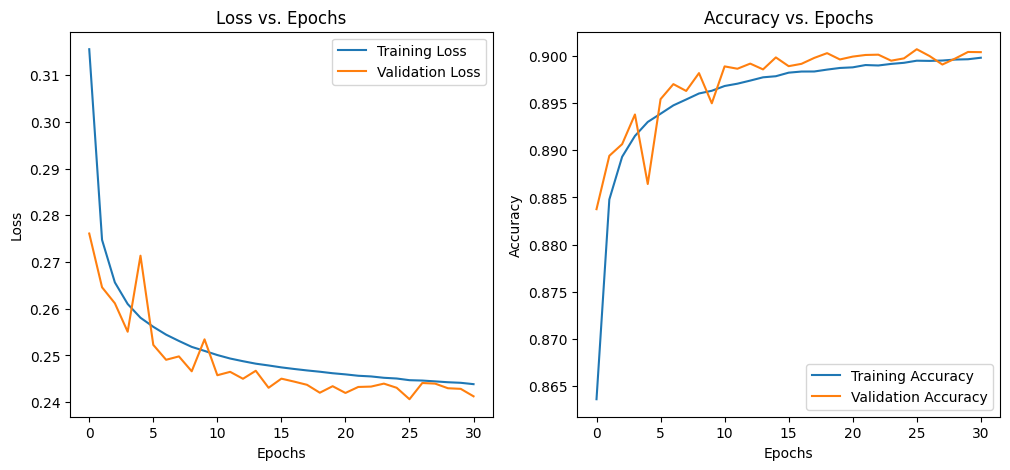

In [34]:
train_data = TensorDataset(Xt_train, yt_train)
val_data = TensorDataset(Xt_val, yt_val)

train_model(model,
            train_data,
            val_data,
            loss_fn,
            optimizer,
            epochs=100)

In [36]:
Xt_val = torch.tensor(X_val, dtype=torch.float)
yt_val = torch.tensor(y_val.to_numpy(), dtype=torch.long)
Xt_test = torch.tensor(X_test, dtype=torch.float)
yt_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

val_data = TensorDataset(Xt_val, yt_val)
test_data = TensorDataset(Xt_test, yt_test)

val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [38]:
def calculate_accuracy(model, data_loader):

    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() >= 0.5).long()
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    return accuracy

val_accuracy = calculate_accuracy(model, val_loader)
test_accuracy = calculate_accuracy(model, test_loader)

print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Validation Accuracy: 0.9004029325628476
Test Accuracy: 0.9005759769043168
